<font size=6>Ocean Data Analysis - Analyzing Sea Surface Temperature w/ Variational Inference</font>

Interesting Research
https://www.nature.com/articles/s41467-018-08066-0

In [1]:
import warnings
warnings.filterwarnings('ignore')

import xarray as xr
!pip install netcdf4
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

import sklearn 
import sklearn.mixture as mix 
import scipy.stats as stats 

import seaborn as sns
sns.set()

In [2]:
# Buoy in Gulf of Maine
ds = xr.open_dataset('https://dods.ndbc.noaa.gov/thredds/dodsC/data/stdmet/44005/44005.ncml')
ds = ds.sel(time=slice('2015-5-23','2023-5-3'))
print(ds)

# Get buoy data from NOAA
noaa_df = ds.to_dataframe().reset_index()
print(noaa_df)

<xarray.Dataset>
Dimensions:                  (latitude: 1, longitude: 1, time: 50754)
Coordinates:
  * latitude                 (latitude) float32 43.2
  * longitude                (longitude) float32 -69.13
  * time                     (time) datetime64[ns] 2015-05-23T00:50:00 ... 20...
Data variables: (12/13)
    wind_dir                 (time, latitude, longitude) float64 ...
    wind_spd                 (time, latitude, longitude) float32 ...
    gust                     (time, latitude, longitude) float32 ...
    wave_height              (time, latitude, longitude) float32 ...
    dominant_wpd             (time, latitude, longitude) timedelta64[ns] ...
    average_wpd              (time, latitude, longitude) timedelta64[ns] ...
    ...                       ...
    air_pressure             (time, latitude, longitude) float32 ...
    air_temperature          (time, latitude, longitude) float32 ...
    sea_surface_temperature  (time, latitude, longitude) float32 ...
    dewpt_tempe

In [3]:
# Get sea surface temps
cov = noaa_df[['time','sea_surface_temperature']]
cov = cov.dropna().reset_index().drop(columns=['index'])
cov['sea_surface_temperature'] = cov['sea_surface_temperature'].rolling(24*14).mean()
cov = cov.dropna()
print(cov)

                     time  sea_surface_temperature
335   2015-06-06 04:50:00                10.050000
336   2015-06-06 05:50:00                10.051786
337   2015-06-06 06:50:00                10.053274
338   2015-06-06 07:50:00                10.055060
339   2015-06-06 08:50:00                10.057440
...                   ...                      ...
48580 2023-03-31 18:50:00                 4.708631
48581 2023-03-31 19:50:00                 4.708036
48582 2023-03-31 20:50:00                 4.707440
48583 2023-03-31 21:50:00                 4.706548
48584 2023-03-31 22:50:00                 4.705060

[48250 rows x 2 columns]


In [5]:
# Fit mixture model 
num_components = 5
dpgmm_model = mix.BayesianGaussianMixture(
    n_components=num_components, 
    weight_concentration_prior_type='dirichlet_process',
    n_init=1,
    max_iter=100)
p = dpgmm_model.fit_predict(cov['sea_surface_temperature'].to_numpy().reshape(-1,1))

# Count States
state_counts = np.zeros(num_components)
for M in p:
  state_counts[M] += 1 
print(state_counts)

[ 9185. 14595. 10748. 10851.  2871.]


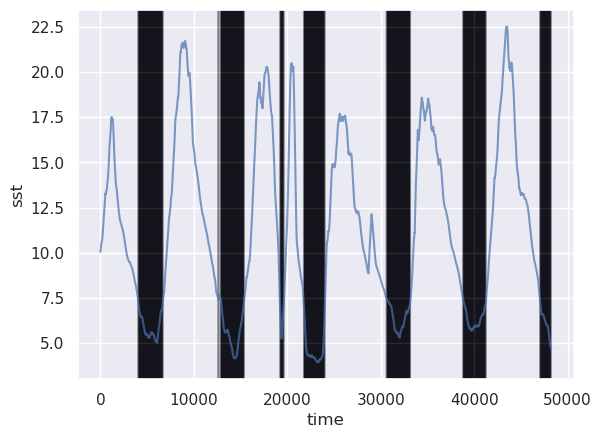

In [6]:
# Plot States
fig2, ax2=plt.subplots()

for M in range(len(p)): 
  if p[M] == p[-1]:
    ax2.axvline(M, color='black', alpha=0.002) 
    
sns.lineplot(data=cov['sea_surface_temperature'].values, ax=ax2, alpha=0.7)
plt.ylabel('sst')
plt.xlabel('time')
plt.show()

2016_01
2016_02
2016_03
2016_04
2016_05
2017_01
2017_02
2017_03
2017_04
2017_05
2018_04
2018_05
2019_01
2019_02
2019_03
2019_04
2019_05
2019_06
2021_01
2021_02
2021_03
2021_04
2021_05
2022_01
2022_02
2022_03
2022_04
2022_05
2023_02
2023_03


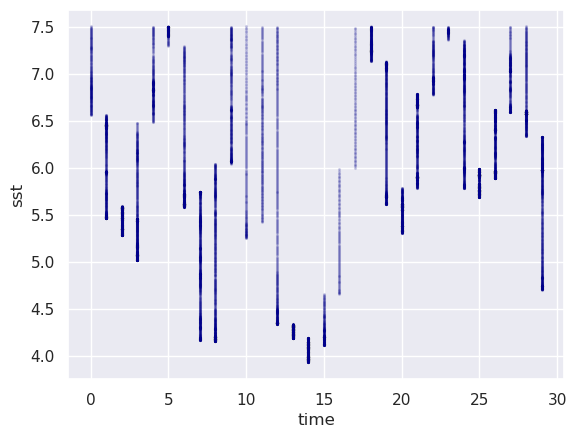

In [14]:
# Plot States Grouped by Year 
fig,ax=plt.subplots()
data={}

for M in range(len(p)): 
  if p[M] == p[-1]:
    yr = str(cov['time'].values[M])[:4]
    mo = str(cov['time'].values[M])[5:7]
    if not f'{yr}_{mo}' in data:
        data[f'{yr}_{mo}'] = []
    data[f'{yr}_{mo}'].append(cov['sea_surface_temperature'].values[M])

i=0
for cluster in data: 
    print(cluster)
    ax.scatter(x=np.full(len(data[cluster]), i), y=data[cluster], alpha=0.15, label=cluster, color='darkblue', s=1.5)
    i=i+1
plt.ylabel('sst')
plt.xlabel('time')
plt.show()
